In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import time
from zipline.api import (
    order,
    record,
    symbol,
    set_benchmark,
)
import pyfolio as pf
import pandas_datareader.data as web
from zipline import run_algorithm
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import warnings
warnings.filterwarnings("ignore")
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap


############
# stock data loader and GRU model
# import StockDate and GRUModel
project_base = Path.cwd().resolve().parent.parent
sys.path.append(str(project_base))
from util import StockData, GRUModel

In [2]:
sns.set_style('whitegrid')
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

In [3]:
ticker = 'NVDA'
start='2001-01-01'
end='2024-12-30'
security = StockData(ticker, start, end)

[*********************100%***********************]  1 of 1 completed


In [4]:
retrain = True
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

gru_model = GRUModel(input_dim, hidden_dim, num_layers, output_dim)
saved_model = Path().cwd().parent / "GRU/gru_stock_pred.pth"
if not saved_model.exists():
    Path.mkdir(Path().cwd().parent / "GRU", exist_ok=True)

if saved_model.parent.exists() and not retrain:
    gru_model.load_state_dict(torch.load(saved_model))
else:
    X_train, y_train, X_test, y_test = security.train_valid_split()
    train_df, test_df = security.get_train_test_data_frame()
    criterion = torch.nn.MSELoss(reduction='mean')
    optimiser = torch.optim.Adam(gru_model.parameters(), lr=0.01)
    # train
    num_epochs = 200
    hist = np.zeros(num_epochs)
    start_time = time.time()
    gru = []
    for t in range(num_epochs):
        y_train_pred = gru_model(X_train)

        loss = criterion(y_train_pred, y_train)
        print("Epoch ", t, "MSE: ", loss.item())
        hist[t] = loss.item()

        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    training_time = time.time()-start_time
    print("Training time: {}".format(training_time))
    torch.save(gru_model.state_dict(), saved_model)

Epoch  0 MSE:  1.1356370449066162
Epoch  1 MSE:  0.6328927278518677
Epoch  2 MSE:  0.29395633935928345
Epoch  3 MSE:  0.04712345451116562
Epoch  4 MSE:  0.05019747465848923
Epoch  5 MSE:  0.14456573128700256
Epoch  6 MSE:  0.07255081087350845
Epoch  7 MSE:  0.00804633367806673
Epoch  8 MSE:  0.005109191406518221
Epoch  9 MSE:  0.02957802079617977
Epoch  10 MSE:  0.047050248831510544
Epoch  11 MSE:  0.04661664739251137
Epoch  12 MSE:  0.032706525176763535
Epoch  13 MSE:  0.015017440542578697
Epoch  14 MSE:  0.002763066440820694
Epoch  15 MSE:  0.0009548488887958229
Epoch  16 MSE:  0.007973984815180302
Epoch  17 MSE:  0.016568409278988838
Epoch  18 MSE:  0.019569402560591698
Epoch  19 MSE:  0.015451867133378983
Epoch  20 MSE:  0.00803601648658514
Epoch  21 MSE:  0.0021805863361805677
Epoch  22 MSE:  0.0003728766751009971
Epoch  23 MSE:  0.002147982595488429
Epoch  24 MSE:  0.005364107433706522
Epoch  25 MSE:  0.0078336913138628
Epoch  26 MSE:  0.008336499333381653
Epoch  27 MSE:  0.00683

In [6]:
# backtesting with zipline
# Initialize the strategy
def initialize(context):
    context.asset = symbol(ticker)  # Replace with your stock ticker
    set_benchmark(context.asset)
    context.lookback = 20  # Lookback window for prediction
    context.predictions = []


# Define the handle_data function
def handle_data(context, data):
    # Example: Use the GRU model to predict next day's price

    lookback_prices = data.history(context.asset, "close", context.lookback, "1d")
    scaled_prices = (lookback_prices - lookback_prices.min()) / (lookback_prices.max() - lookback_prices.min())
    prediction = predict_next_day(scaled_prices)  # Your GRU prediction function

    # Decision: Buy or Sell
    current_price = data.current(context.asset, "price")
    if prediction > current_price:
        order(context.asset, 10)  # Buy
        decision = 'buy'
    elif prediction < current_price:
        order(context.asset, -10)  # Sell
        decision = 'sell'
    print(f"Handling data for {data.current_dt.date()}, current price: {current_price}, prediction: {prediction}, decision: {decision}")

    # Record data for analysis
    # how can you use this?
    record(prediction=prediction, price=current_price, decision=decision)


# Example: Dummy function for prediction
def predict_next_day(scaled_prices):

    scaled_prices = np.asarray(scaled_prices)
    scaled_prices = scaled_prices[np.newaxis, :, np.newaxis]
    scaled_prices_tensor = torch.from_numpy(scaled_prices).to(torch.float32)
    pred = gru_model(scaled_prices_tensor)
    pred =  security.scaler.inverse_transform(pred.detach().numpy().reshape(-1,1))
    return pred.reshape(-1)[0]

def analyze(perf):
    ax1 = plt.subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax2 = plt.subplot(212, sharex=ax1)
    perf.price.plot(ax=ax2)
    plt.gcf().set_size_inches(18, 8)
    plt.show()

Handling data for 2015-01-02, current price: 20.13, prediction: 24.760995864868164, decision: buy
Handling data for 2015-01-05, current price: 19.79, prediction: 23.055889129638672, decision: buy
Handling data for 2015-01-06, current price: 19.19, prediction: 21.66210174560547, decision: buy
Handling data for 2015-01-07, current price: 19.135, prediction: 19.476116180419922, decision: buy
Handling data for 2015-01-08, current price: 19.86, prediction: 20.630529403686523, decision: buy
Handling data for 2015-01-09, current price: 19.94, prediction: 22.208478927612305, decision: buy
Handling data for 2015-01-12, current price: 19.69, prediction: 22.30632781982422, decision: buy
Handling data for 2015-01-13, current price: 19.655, prediction: 21.984943389892578, decision: buy
Handling data for 2015-01-14, current price: 19.740000000000002, prediction: 22.029661178588867, decision: buy
Handling data for 2015-01-15, current price: 19.6, prediction: 21.586387634277344, decision: buy
Handling

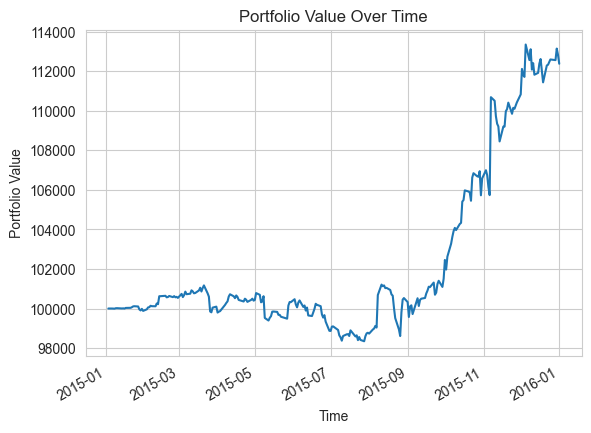

In [14]:
# Run the backtest
if __name__ == "__main__":
    # I picked two random time. Obviously, there are a lot of parameters you can tune
    start = pd.Timestamp("2015-01-01", tz=None)
    end = pd.Timestamp("2015-12-31", tz=None)
    result = run_algorithm(start=start,
                           end=end,
                           initialize=initialize,
                           handle_data=handle_data,
                           capital_base=100000,
                           bundle="quandl")

    result.portfolio_value.plot(title="Portfolio Value Over Time")
    plt.xlabel("Time")  # Optional: Add a label to the x-axis
    plt.ylabel("Portfolio Value")  # Optional: Add a label to the y-axis
    plt.savefig("portfolio_value.png")
    plt.show()

In [16]:
result

,period_open,period_close,long_exposure,short_value,short_exposure,gross_leverage,capital_used,pnl,net_leverage,orders,...,sharpe,max_drawdown,algorithm_period_return,sortino,max_leverage,excess_return,trading_days,treasury_period_return,period_label,algo_volatility
2015-01-02 21:00:00+00:00,2015-01-02 14:31:00+00:00,2015-01-02 21:00:00+00:00,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,"[{'id': '00c78670c19c4af580326328c39aed2d', 'd...",...,NaN,0.000000,0.000000,NaN,0.000000,0.0,1,0.0,2015-01,NaN
2015-01-05 21:00:00+00:00,2015-01-05 14:31:00+00:00,2015-01-05 21:00:00+00:00,197.90,0.0,0.0,0.001979,-198.008950,-0.108950,0.001979,"[{'id': '00c78670c19c4af580326328c39aed2d', 'd...",...,-11.224972,-0.000001,-0.000001,-11.224972,0.001979,0.0,2,0.0,2015-01,0.000012
2015-01-06 21:00:00+00:00,2015-01-06 14:31:00+00:00,2015-01-06 21:00:00+00:00,383.80,0.0,0.0,0.003838,-192.005950,-6.105950,0.003838,"[{'id': '03fc176424b04615bf8988bfaece4f54', 'd...",...,-9.411520,-0.000062,-0.000062,-9.327203,0.003838,0.0,3,0.0,2015-01,0.000555
2015-01-07 21:00:00+00:00,2015-01-07 14:31:00+00:00,2015-01-07 21:00:00+00:00,574.05,0.0,0.0,0.005741,-191.455675,-1.205675,0.005741,"[{'id': '2c1a0a33b9864d719da21907d069d3a7', 'd...",...,-10.205417,-0.000074,-0.000074,-9.462059,0.005741,0.0,4,0.0,2015-01,0.000458
2015-01-08 21:00:00+00:00,2015-01-08 14:31:00+00:00,2015-01-08 21:00:00+00:00,794.40,0.0,0.0,0.007943,-198.709300,21.640700,0.007943,"[{'id': 'a2a5d50017a44c328d348924758b5209', 'd...",...,4.180204,-0.000074,0.000142,16.219531,0.007943,0.0,5,0.0,2015-01,0.001715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-24 18:00:00+00:00,2015-12-24 14:31:00+00:00,2015-12-24 18:00:00+00:00,36155.30,0.0,0.0,0.321107,331.524150,126.324150,0.321107,"[{'id': '4e4c7236dfe74f50af7c51c1e846cd3d', 'd...",...,1.666855,-0.027926,0.125958,3.506214,0.370545,0.0,248,0.0,2015-12,0.073950
2015-12-28 21:00:00+00:00,2015-12-28 14:31:00+00:00,2015-12-28 21:00:00+00:00,35791.20,0.0,0.0,0.317966,331.224300,-32.875700,0.317966,"[{'id': '31db09085f8548b9b063c9fa4842d026', 'd...",...,1.659420,-0.027926,0.125629,3.490622,0.370545,0.0,249,0.0,2015-12,0.073805
2015-12-29 21:00:00+00:00,2015-12-29 14:31:00+00:00,2015-12-29 21:00:00+00:00,36037.60,0.0,0.0,0.318505,336.621600,583.021600,0.318505,"[{'id': '8449e5dffa564e83aa2c5adca351d6a0', 'd...",...,1.723470,-0.027926,0.131460,3.632735,0.370545,0.0,250,0.0,2015-12,0.073807
2015-12-30 21:00:00+00:00,2015-12-30 14:31:00+00:00,2015-12-30 21:00:00+00:00,35393.40,0.0,0.0,0.313673,333.723050,-310.476950,0.313673,"[{'id': 'bbe29dbf193f46e49eba4a617caf246e', 'd...",...,1.681005,-0.027926,0.128355,3.535730,0.370545,0.0,251,0.0,2015-12,0.073731


In [17]:
(result.price[-1] - result.price[0])/result.price[0]

0.637357178340785

In [18]:
(result.portfolio_value[-1] - result.portfolio_value[0])/result.portfolio_value[0]

0.12379506250001301

In [19]:
transactions = result.loc[:, ['price', 'prediction', 'decision']]
transactions

,price,prediction,decision
2015-01-02 21:00:00+00:00,20.130,24.760996,buy
2015-01-05 21:00:00+00:00,19.790,23.055889,buy
2015-01-06 21:00:00+00:00,19.190,21.662102,buy
2015-01-07 21:00:00+00:00,19.135,19.476116,buy
2015-01-08 21:00:00+00:00,19.860,20.630529,buy
...,...,...,...
2015-12-24 18:00:00+00:00,33.170,27.853010,sell
2015-12-28 21:00:00+00:00,33.140,27.502539,sell
2015-12-29 21:00:00+00:00,33.680,28.443594,sell
2015-12-30 21:00:00+00:00,33.390,29.180902,sell


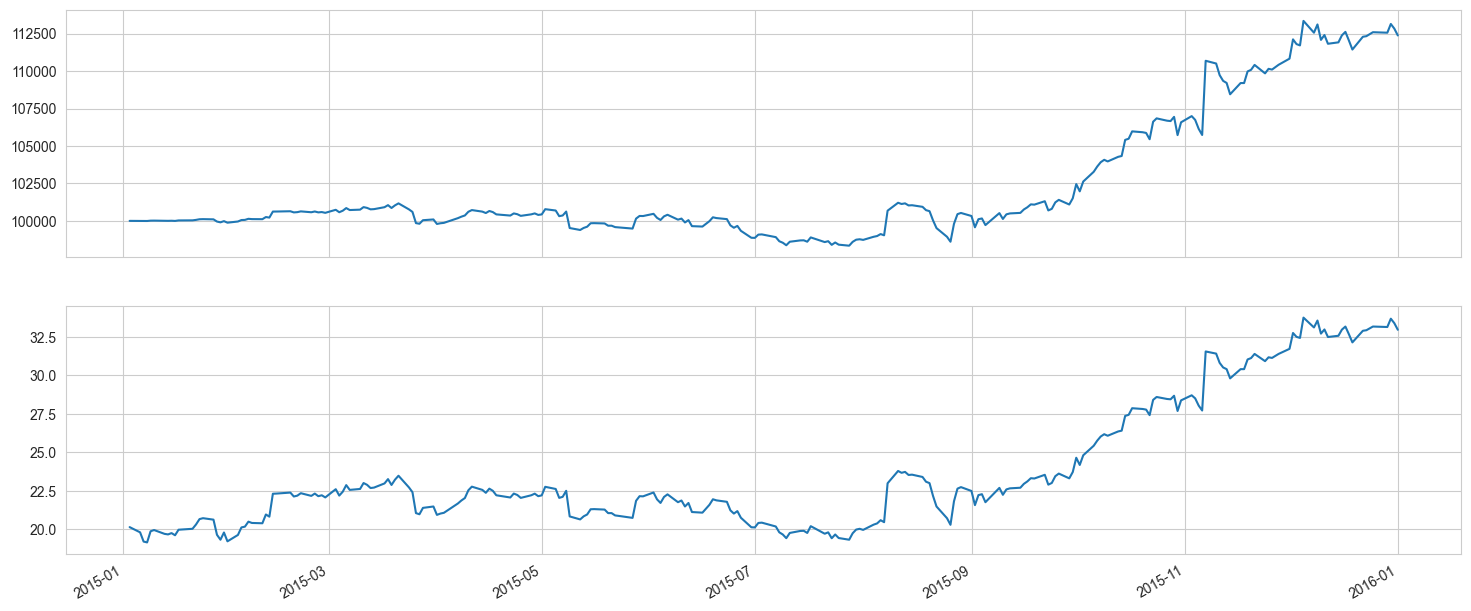

In [20]:
analyze(perf=result)

In [21]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(result)

In [26]:
benchmark = web.DataReader('SP500', 'fred', '2014', '2016').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

In [27]:
LIVE_DATE = '2015-07-01'

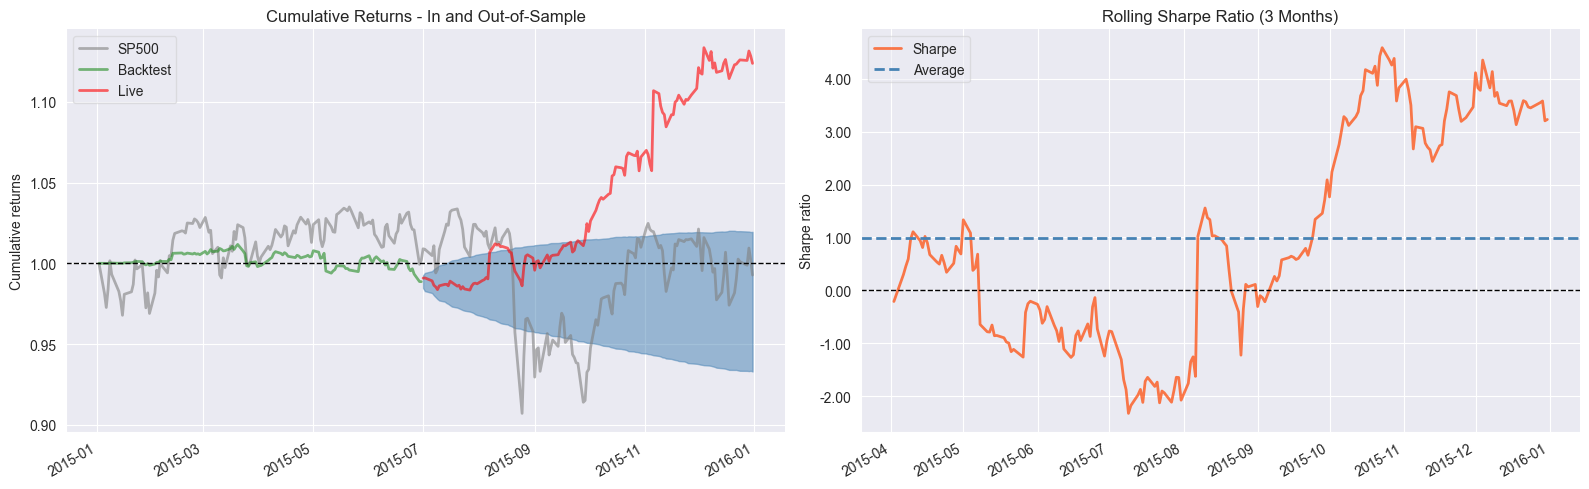

In [28]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     live_start_date=LIVE_DATE,
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout();

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.79,2015-03-20,2015-07-27,2015-08-10,102
1,2.57,2015-08-10,2015-08-25,2015-09-21,31
2,2.02,2015-11-06,2015-11-13,2015-11-30,17
3,1.69,2015-12-04,2015-12-18,NaT,NaN
4,1.18,2015-11-02,2015-11-05,2015-11-06,5


Stress Events,mean,min,max
Fall2015,0.04%,-0.75%,1.21%
New Normal,0.05%,-1.14%,4.68%


Top 10 long positions of all time,max
sid,
NVDA,37.05%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
NVDA,37.05%


Summary stats,All trades,Long trades
Total number of round_trips,73.00,73.00
Percent profitable,0.74,0.74
Winning round_trips,54.00,54.00
Losing round_trips,19.00,19.00
Even round_trips,0.00,0.00


PnL stats,All trades,Long trades
Total profit,$12382.02,$12382.02
Gross profit,$12783.29,$12783.29
Gross loss,$-401.27,$-401.27
Profit factor,$31.86,$31.86
Avg. trade net profit,$169.62,$169.62
Avg. winning trade,$236.73,$236.73
Avg. losing trade,$-21.12,$-21.12
Ratio Avg. Win:Avg. Loss,$11.21,$11.21
Largest winning trade,$9633.54,$9633.54
Largest losing trade,$-31.96,$-31.96


Duration stats,All trades,Long trades
Avg duration,171 days 17:51:46.849315068,171 days 17:51:46.849315068
Median duration,144 days 23:00:00,144 days 23:00:00
Longest duration,257 days 01:00:00,257 days 01:00:00
Shortest duration,30 days 00:00:00,30 days 00:00:00


Return stats,All trades,Long trades
Avg returns all round_trips,0.15%,0.15%
Avg returns winning,0.21%,0.21%
Avg returns losing,-0.02%,-0.02%
Median returns all round_trips,0.02%,0.02%
Median returns winning,0.07%,0.07%
Median returns losing,-0.02%,-0.02%
Largest winning trade,8.51%,8.51%
Largest losing trade,-0.03%,-0.03%


Symbol stats,NVDA
Avg returns all round_trips,0.15%
Avg returns winning,0.21%
Avg returns losing,-0.02%
Median returns all round_trips,0.02%
Median returns winning,0.07%
Median returns losing,-0.02%
Largest winning trade,8.51%
Largest losing trade,-0.03%


Profitability (PnL / PnL total) per name,
symbol,
NVDA,100.00%


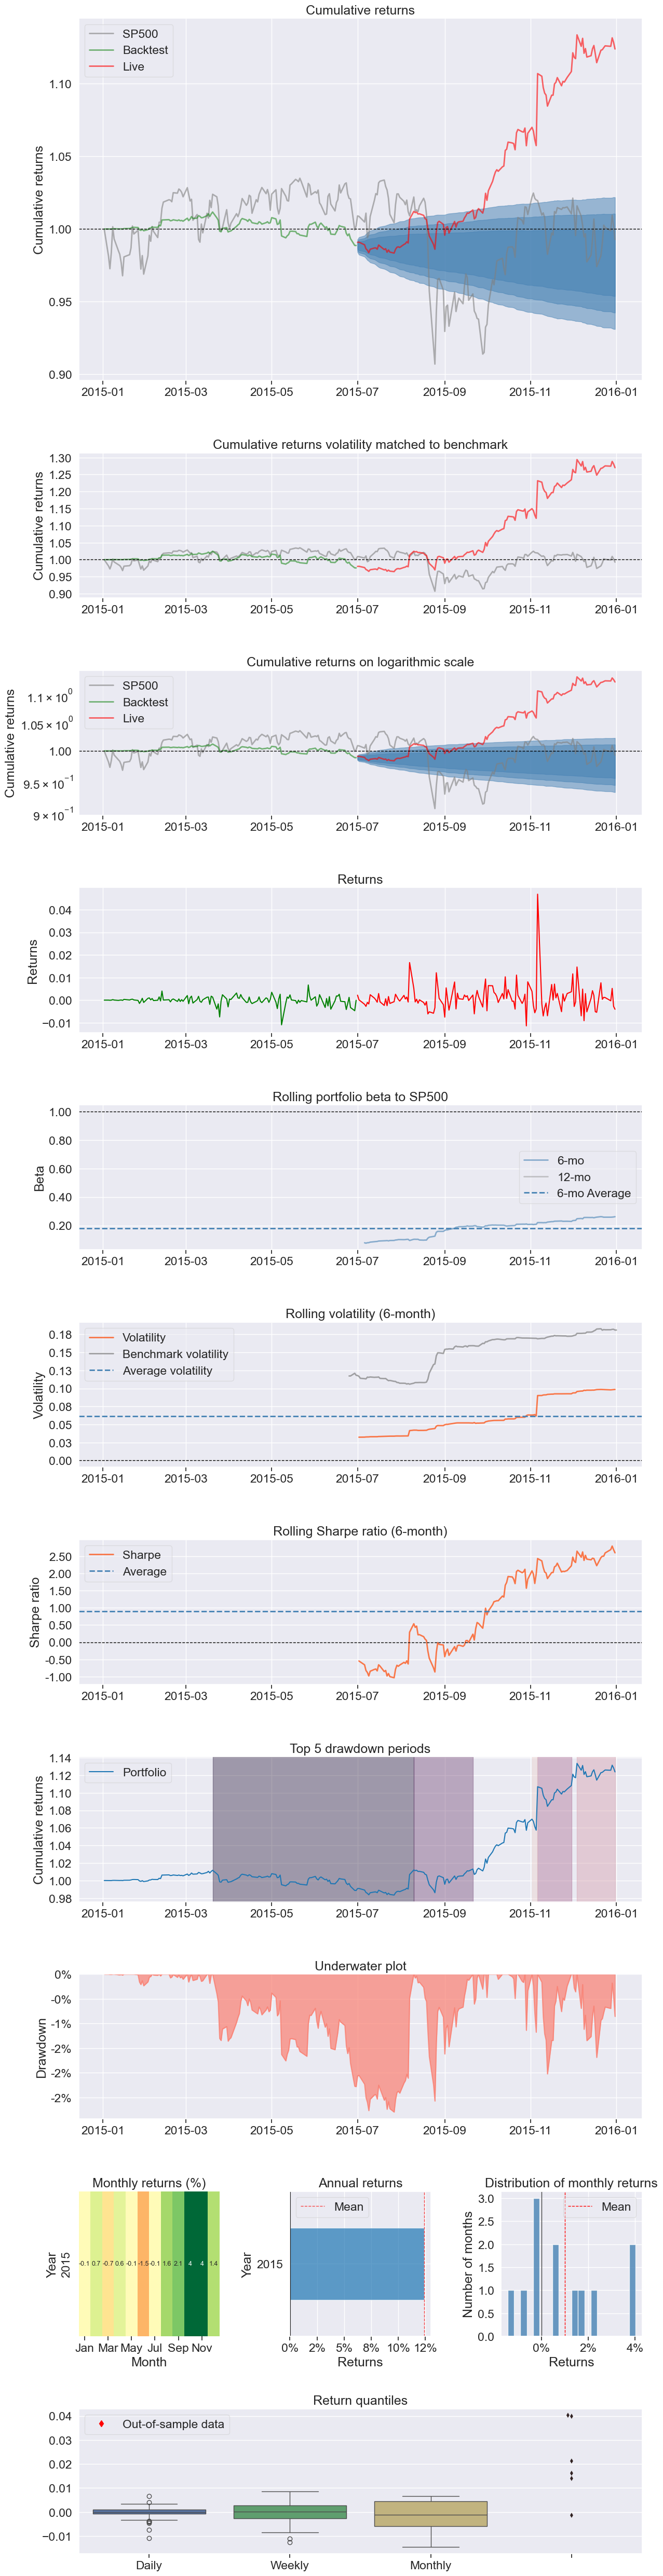

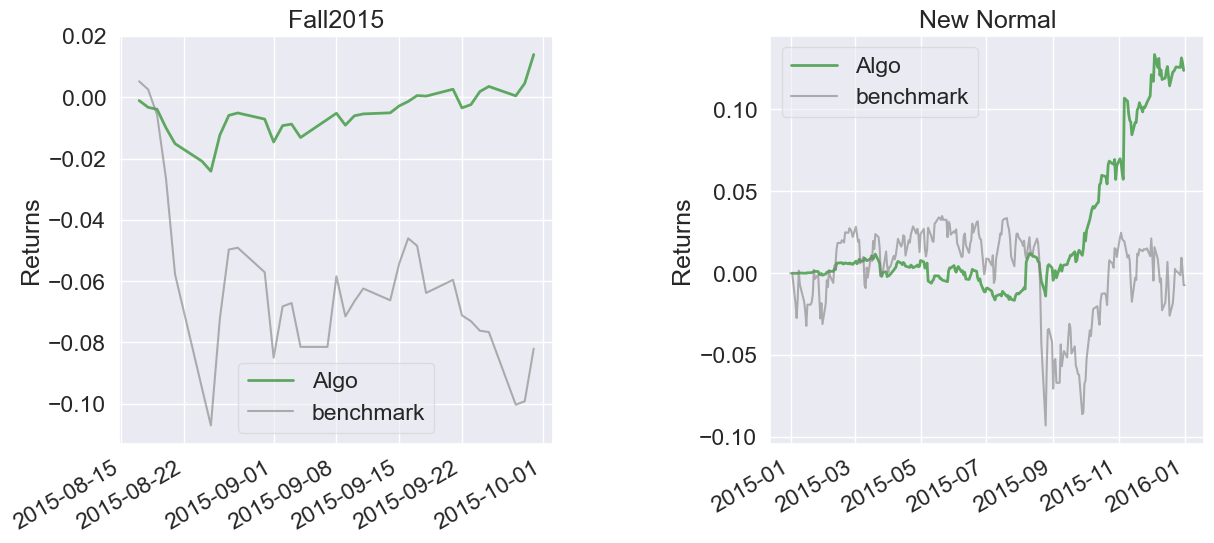

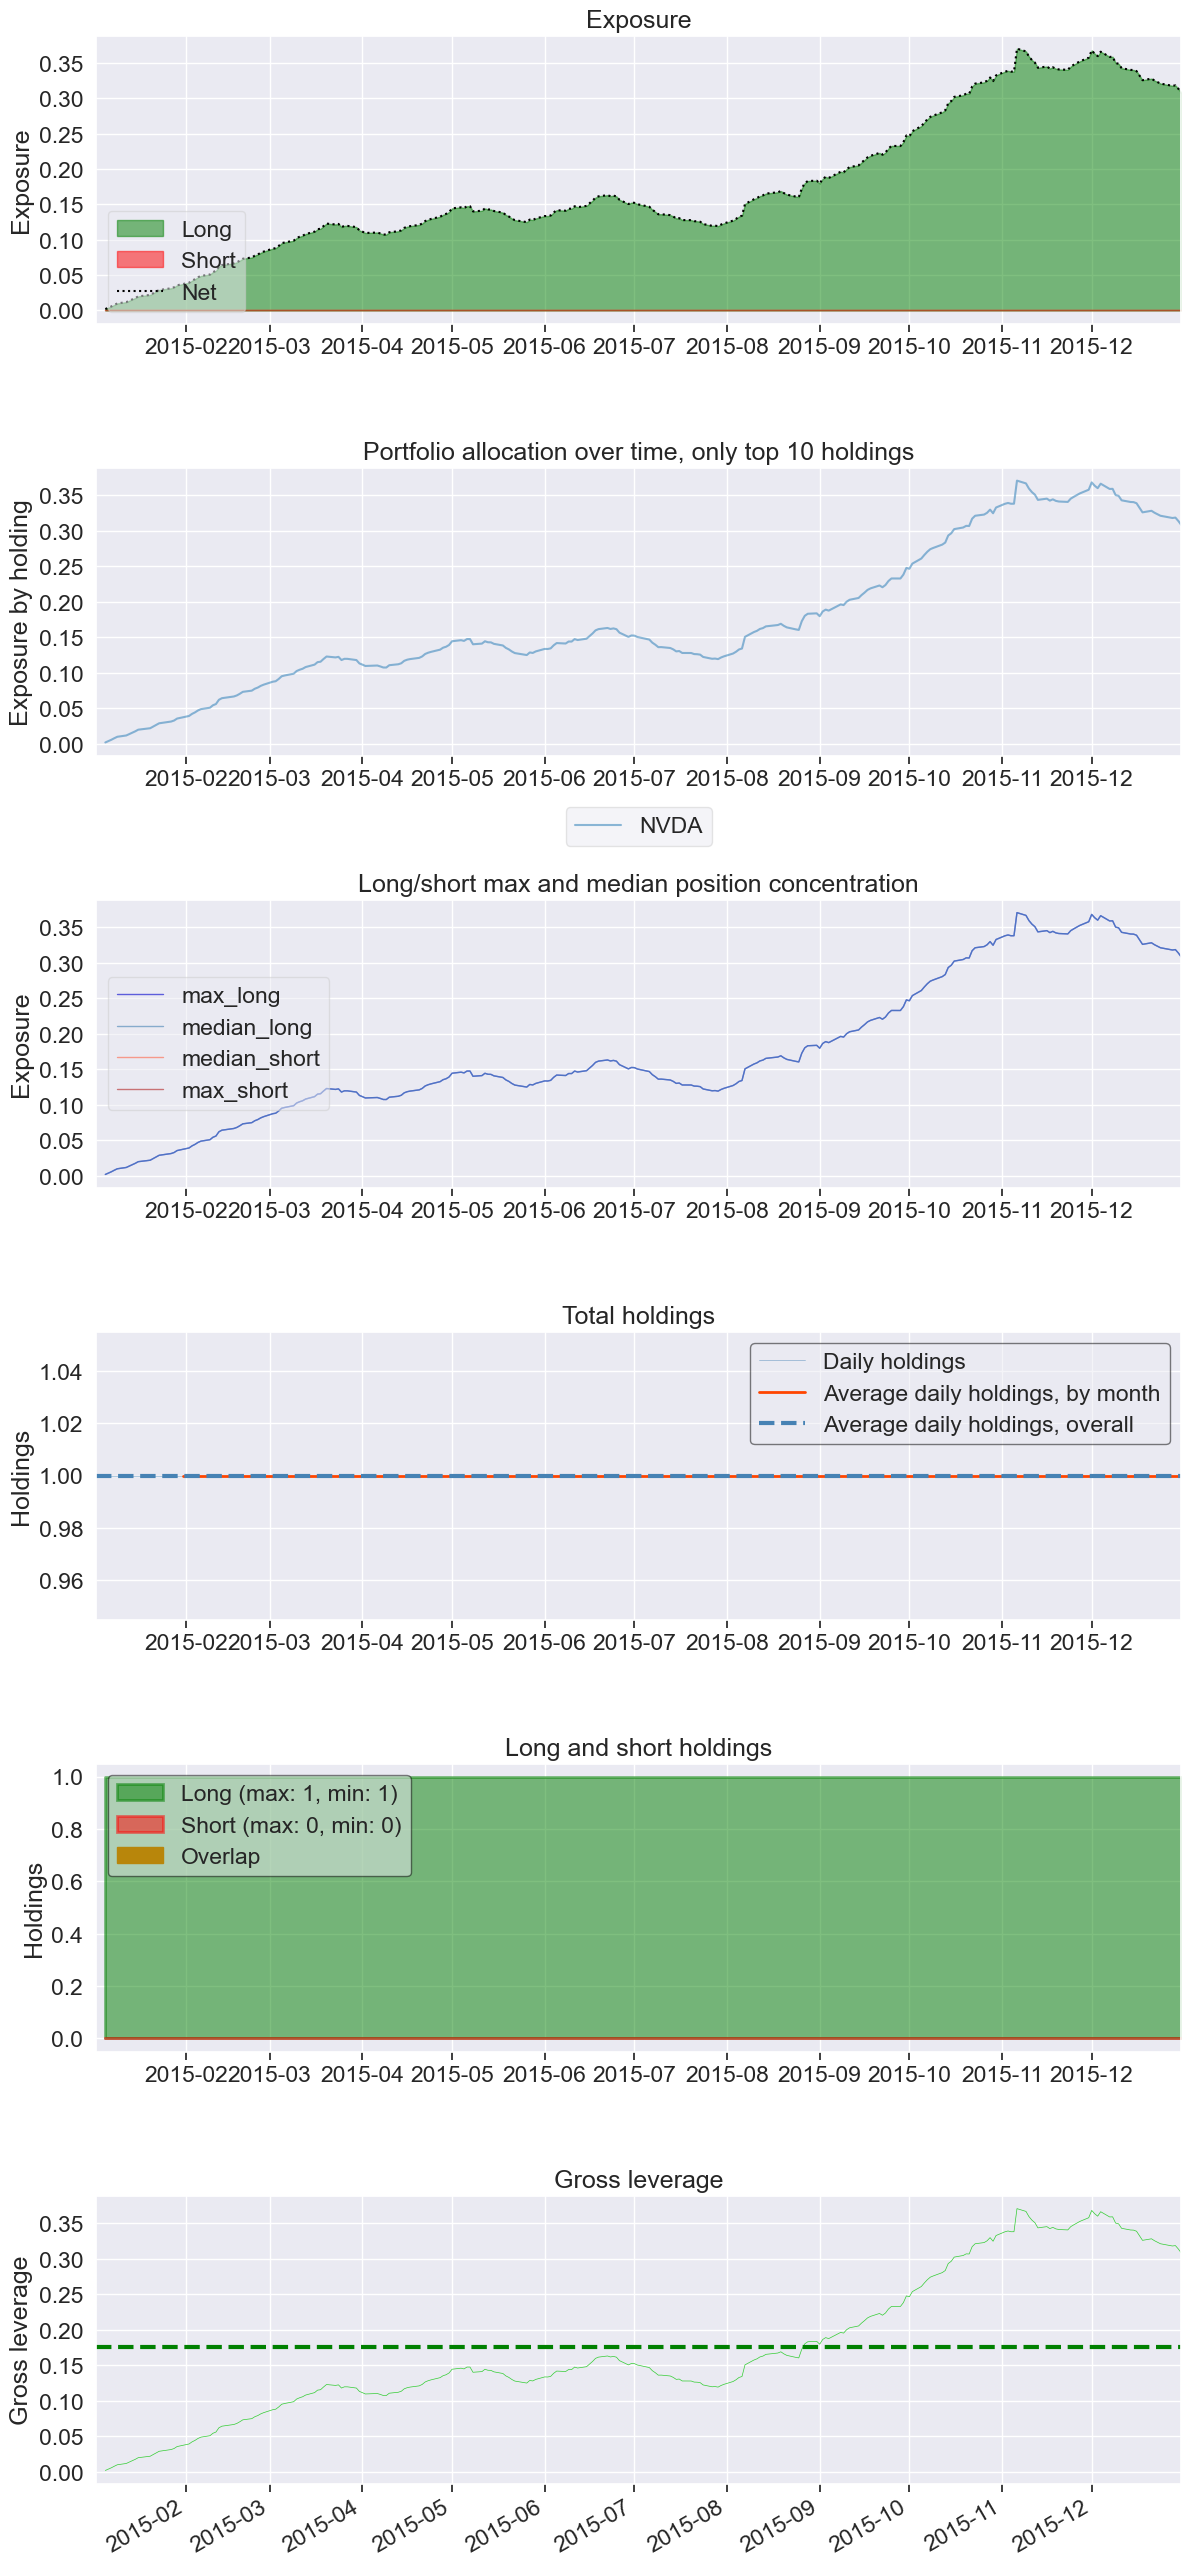

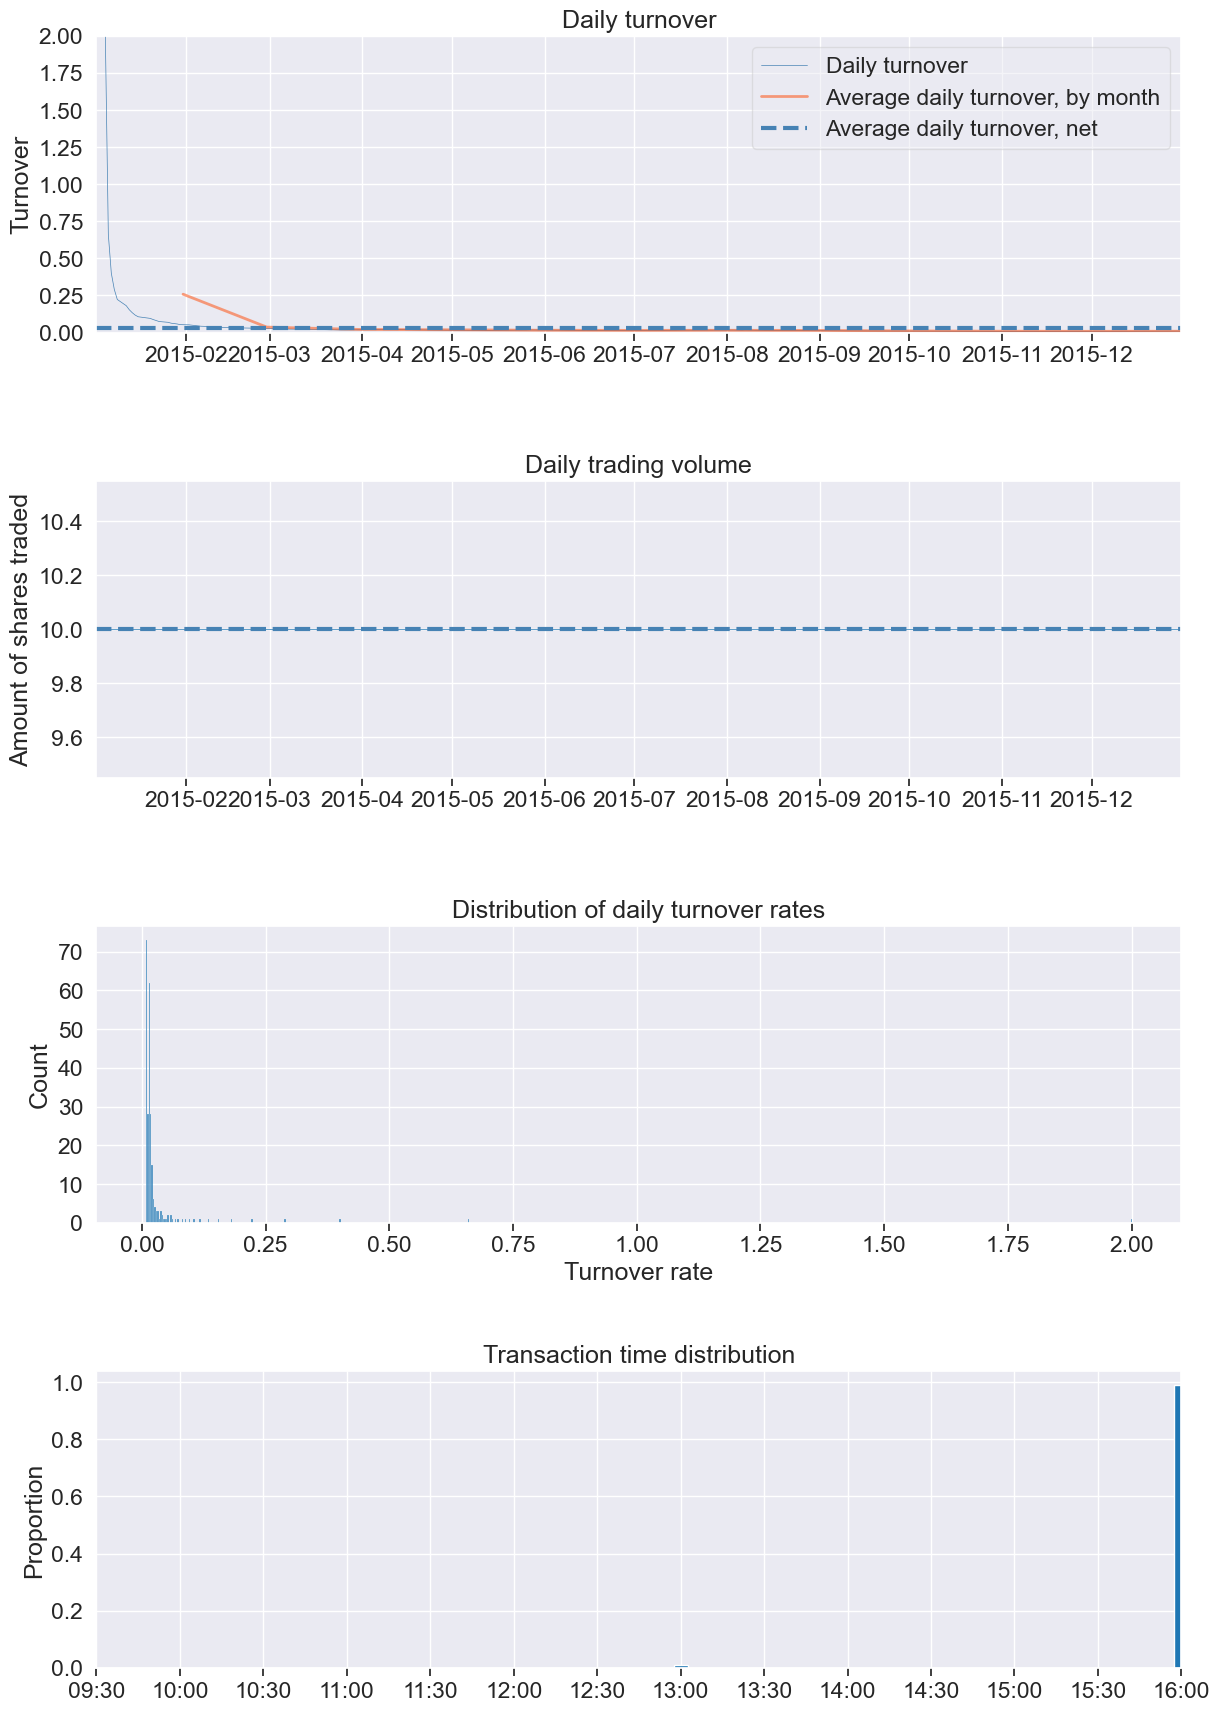

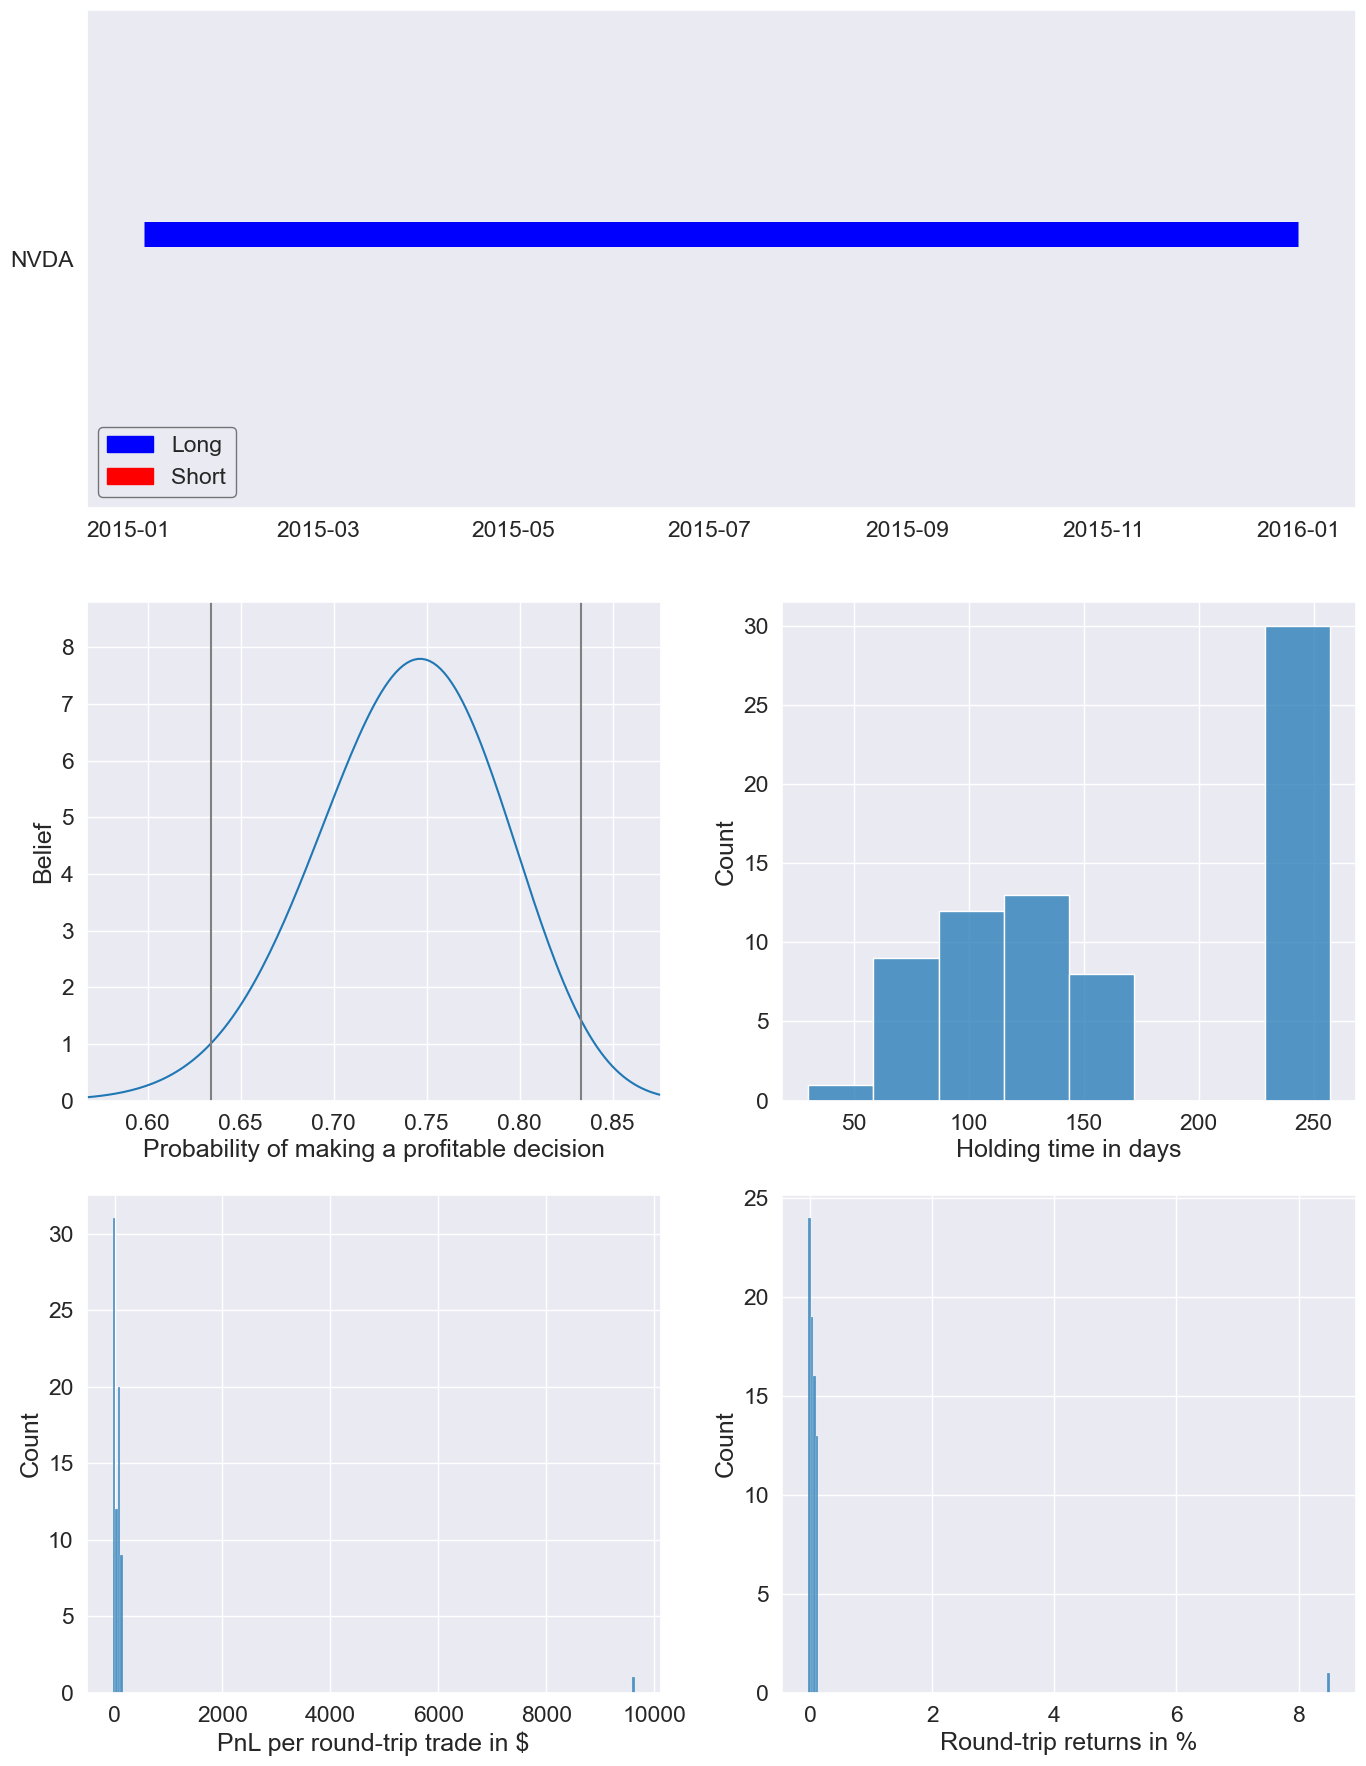

In [29]:
pf.create_full_tear_sheet(returns,
                          positions=positions,
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date=LIVE_DATE,
                          round_trips=True)